## week0_09 practice: PyTorch practice, hints and Dataloaders

Credits:
* First part is based on YSDA [Practical RL course week04 materials](https://github.com/yandexdataschool/Practical_RL/tree/master/week04_%5Brecap%5D_deep_learning).
* Second part is based on PyTorch official tutorials and [this kaggle kernel](https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader)
* Third part is based on PyTorch tutorial by [Stanford CS 231n course](http://cs231n.stanford.edu)

![img](https://pytorch.org/tutorials/_static/pytorch-logo-dark.svg)

__This notebook__ will remind you how to use pytorch low and high-level core. You can install it [here](http://pytorch.org/).

__Pytorch feels__ differently than other frameworks (like tensorflow/theano) on almost every level. TensorFlow makes your code live in two "worlds" simultaneously:  symbolic graphs and actual tensors. First you declare a symbolic "recipe" of how to get from inputs to outputs, then feed it with actual minibatches of data.  In pytorch, __there's only one world__: all tensors have a numeric value.

You compute outputs on the fly without pre-declaring anything. The code looks exactly as in pure numpy with one exception: pytorch computes gradients for you. And can run stuff on GPU. And has a number of pre-implemented building blocks for your neural nets. [And a few more things.](https://medium.com/towards-data-science/pytorch-vs-tensorflow-spotting-the-difference-25c75777377b)

Let's dive into it!

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import transforms

C:\Users\user\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Task 1: Tensormancy

__1.1 The [_disclaimer_](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)__

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (6 \cdot \theta) ) \cdot (1 + 0.01 \cdot cos(24 \cdot \theta)) \cdot (0.5 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (10 + sin(10 \cdot \theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

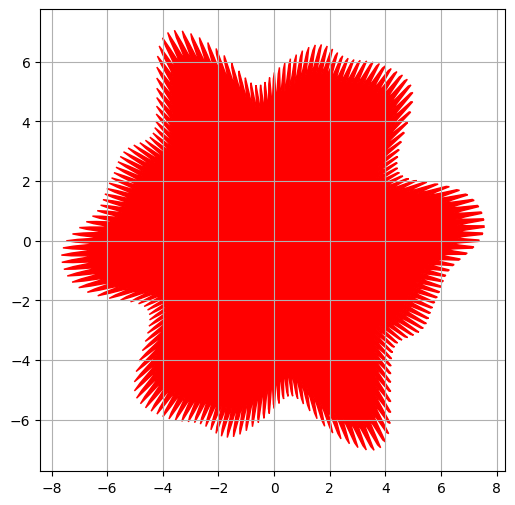

In [2]:
theta = torch.linspace(-np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = (1 + 0.9 * torch.cos(6  * theta)) + (1 + 0.01 * torch.cos(24*theta)) * (0.5 + 0.05 * torch.cos(200 * theta)) * (10 + torch.sin(10 * theta))
# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = rho * torch.cos(theta)
y = rho * torch.sin(theta)


plt.figure(figsize=(6, 6))
plt.fill(x.numpy(), y.numpy(), color='red')
plt.grid()

### Task 2: Using the Dataloader

In [3]:
from torch import nn
from torch.nn import functional as F

In [ ]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/week0_08_dropout_batchnorm/notmnist.py -nc

In [4]:
from notmnist import load_notmnist
X_train, y_train, X_test, y_test = load_notmnist()

Extracting ...
Parsing...
found broken img: ./notMNIST_small\A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small\F\Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


In [5]:
class DatasetMNIST(Dataset):
    def __init__(self, path='./notMNIST_small', letters='ABCDEFGHIJ', transform=None):
        self.data, self.labels, _ ,_  = load_notmnist(path=path, letters=letters, test_size=0)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        image = self.data[index].transpose(1, 2, 0)
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [6]:
full_dataset = DatasetMNIST('./notMNIST_small', 'AB', transform=None)

Parsing...
found broken img: ./notMNIST_small\A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [7]:
# we can access and get data with index by __getitem__(index)
img, lab = full_dataset.__getitem__(0)

print(img.shape)
print(type(img))

(28, 28, 1)
<class 'numpy.ndarray'>


In [8]:
a = torchvision.transforms.ToTensor()

a(img).shape

torch.Size([1, 28, 28])

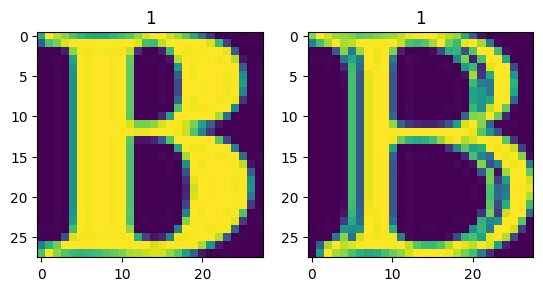

In [9]:
inds = np.random.randint(len(full_dataset), size=2)

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(full_dataset[inds[i]][0].reshape([28,28]))
    plt.title(str(full_dataset[inds[i]][1]))

#### To the DataLoader

In [10]:
train_loader = DataLoader(full_dataset, batch_size=8, shuffle=True)

We can use dataloader as iterator by using iter() function.

In [11]:
train_iter = iter(train_loader)
print(type(train_iter))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>


We can look at images and labels of batch size by extracting data `.next()` method.

In [13]:
images, labels = next(train_iter)

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

images shape on batch size = torch.Size([8, 28, 28, 1])
labels shape on batch size = torch.Size([8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\user\AppData\Roaming\Python\Python38\site-packages\matplotlib\text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


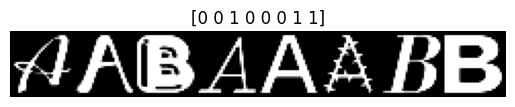

In [14]:
# make grid takes tensor as arg
# tensor : (batchsize, channels, height, width)
grid = torchvision.utils.make_grid(images.permute([0, 3, 1, 2]))

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy());

And now with transformations:

In [15]:
train_dataset_with_transform = DatasetMNIST(
    transform=torchvision.transforms.ToTensor()
)

Parsing...
found broken img: ./notMNIST_small\A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small\F\Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


In [16]:
img, lab = train_dataset_with_transform.__getitem__(0)

print('image shape at the first row : {}'.format(img.size()))

image shape at the first row : torch.Size([1, 28, 28])


In [18]:
train_loader_tr = DataLoader(train_dataset_with_transform, batch_size=8, shuffle=True)

train_iter_tr = iter(train_loader_tr)
print(type(train_iter_tr))

images, labels = next(train_iter_tr)

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([8, 1, 28, 28])
labels shape on batch size = torch.Size([8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\user\AppData\Roaming\Python\Python38\site-packages\matplotlib\text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


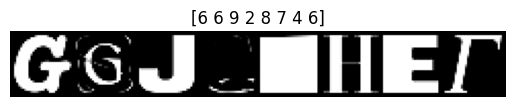

In [19]:
grid = torchvision.utils.make_grid(images)

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy());

### Composing several transformations

If you want to take data augmentation, you have to make List using `torchvision.transforms.Compose`

```
class Compose(object):
    """Composes several transforms together.
    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.
    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string
```


this function can convert some image by order within `__call__` method.

In [20]:
class Flatten():
    def __call__(self, pic):
        return pic.flatten()

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [21]:
a = Flatten()

In [22]:
a(img).shape

torch.Size([784])

In [23]:
new_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    Flatten()
])

# Putting all together

In [24]:
import time

from IPython.display import clear_output

In [25]:
# use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [26]:
def subset_ind(dataset, ratio: float):
#     return ### YOUR CODE HERE
    return np.random.choice(len(dataset), size=int(ratio*len(dataset)), replace=False)

In [27]:
dataset = DatasetMNIST(
    './notMNIST_small',
#     'AB',
    transform=new_transform
)

shrink_inds = subset_ind(dataset, 0.2)
dataset = Subset(dataset, shrink_inds)

print(f'\n\n dataset size: {len(dataset)}, labels: {np.unique(dataset.dataset.labels)}')

Parsing...
found broken img: ./notMNIST_small\A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small\F\Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


 dataset size: 3744, labels: [0 1 2 3 4 5 6 7 8 9]


In [28]:
val_size = 0.2
val_inds = subset_ind(dataset, val_size)

train_dataset = Subset(dataset, [i for i in range(len(dataset)) if i not in val_inds])
val_dataset = Subset(dataset, val_inds)

print(f'  training size: {len(train_dataset)}\nvalidation size: {len(val_dataset)}')

  training size: 2996
validation size: 748


In [29]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [31]:
train_iter = iter(train_loader)
print(type(train_iter))

images, labels = next(train_iter)

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([32, 784])
labels shape on batch size = torch.Size([32])


In [65]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 10),
    nn.Sigmoid(),
)
model.to(device, torch.float32)
loss_func = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [74]:
def train_model(model, train_loader, val_loader, loss_func, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            ### YOUR CODE HERE
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the
            pred = model.forward(X_batch) 
            loss = loss_func(pred, y_batch.long())
            loss.backward()
            opt.step()
            opt.zero_grad()

            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                ### YOUR CODE HERE
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(X_batch)
                loss = loss_func(pred, y_batch.long())
                pred = pred.max(dim = 1)[1]
                ep_val_loss.append(loss.item())
                accr = (pred == y_batch).cpu().detach().numpy().mean()
                ep_val_accuracy.append(accr)

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [67]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 0.494s
	  training loss: 1.862143
	validation loss: 1.726729
	validation accuracy: 0.848
Epoch 2 of 30 took 0.637s
	  training loss: 1.702968
	validation loss: 1.683830
	validation accuracy: 0.858
Epoch 3 of 30 took 0.589s
	  training loss: 1.666182
	validation loss: 1.656196
	validation accuracy: 0.868
Epoch 4 of 30 took 0.672s
	  training loss: 1.647162
	validation loss: 1.652279
	validation accuracy: 0.852
Epoch 5 of 30 took 0.627s
	  training loss: 1.635439
	validation loss: 1.645015
	validation accuracy: 0.863
Epoch 6 of 30 took 0.817s
	  training loss: 1.625516
	validation loss: 1.636743
	validation accuracy: 0.862
Epoch 7 of 30 took 3.307s
	  training loss: 1.617795
	validation loss: 1.630558
	validation accuracy: 0.862
Epoch 8 of 30 took 1.105s
	  training loss: 1.611977
	validation loss: 1.625749
	validation accuracy: 0.860
Epoch 9 of 30 took 0.722s
	  training loss: 1.606726
	validation loss: 1.628444
	validation accuracy: 0.862
Epoch 10 of 30 took 0.694s
	

In [68]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

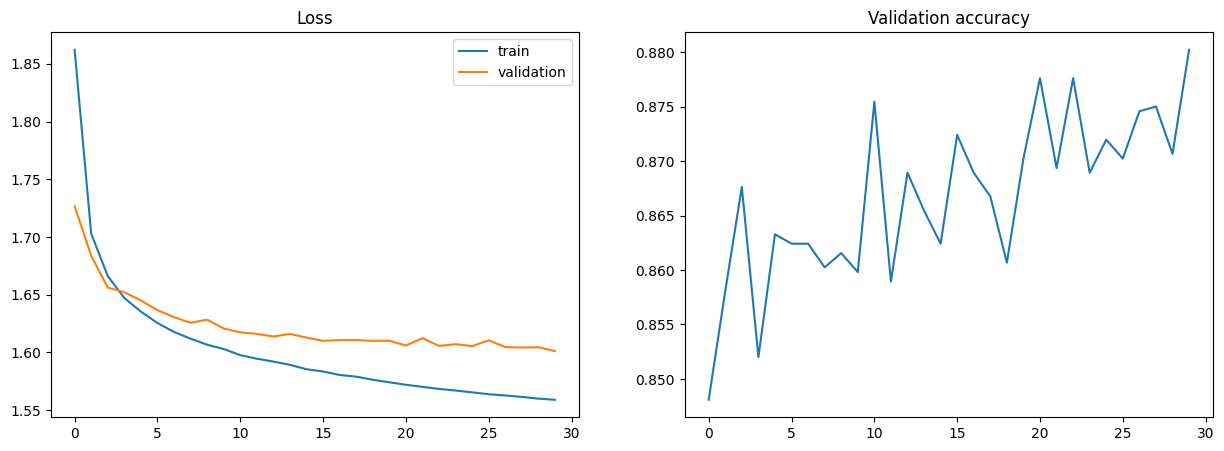

In [69]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Real network

In [72]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
    nn.Sigmoid(),
)
model.to(device, torch.float32)
loss_func = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [75]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 2.138s
	  training loss: 1.702373
	validation loss: 1.594896
	validation accuracy: 0.860
Epoch 2 of 30 took 1.791s
	  training loss: 1.579085
	validation loss: 1.577562
	validation accuracy: 0.876
Epoch 3 of 30 took 2.432s
	  training loss: 1.552515
	validation loss: 1.564672
	validation accuracy: 0.884
Epoch 4 of 30 took 4.081s
	  training loss: 1.538595
	validation loss: 1.558662
	validation accuracy: 0.893
Epoch 5 of 30 took 3.296s
	  training loss: 1.529140
	validation loss: 1.561896
	validation accuracy: 0.896
Epoch 6 of 30 took 3.016s
	  training loss: 1.521146
	validation loss: 1.556039
	validation accuracy: 0.899
Epoch 7 of 30 took 2.446s
	  training loss: 1.519987
	validation loss: 1.560334
	validation accuracy: 0.901
Epoch 8 of 30 took 2.250s
	  training loss: 1.512792
	validation loss: 1.550397
	validation accuracy: 0.893
Epoch 9 of 30 took 2.866s
	  training loss: 1.507787
	validation loss: 1.550808
	validation accuracy: 0.906
Epoch 10 of 30 took 2.232s
	

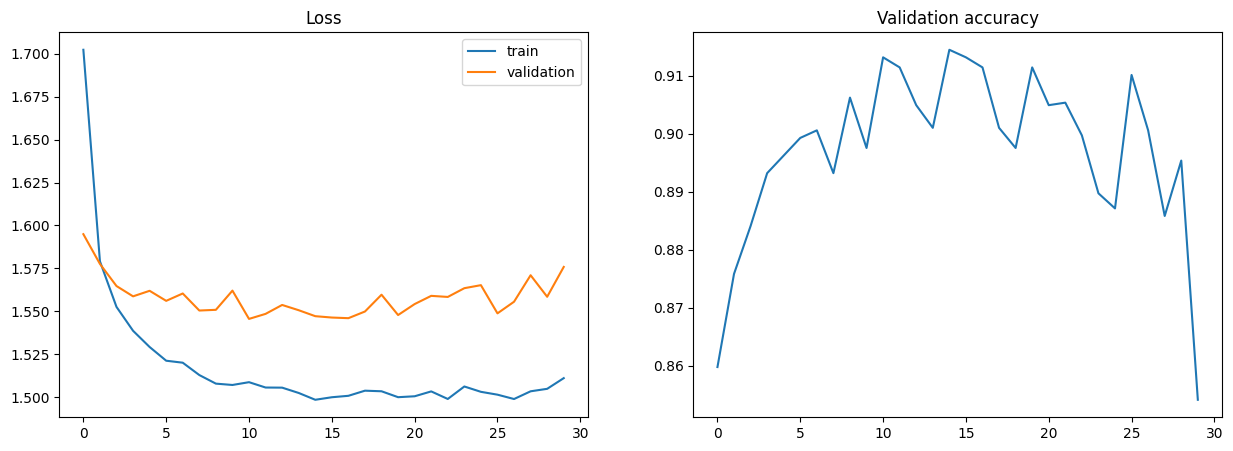

In [76]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Your turn
Try to add some additional transformations (e.g. random crop, rotation etc.) and train your model!

### Dropout try

In [77]:
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
    nn.Sigmoid(),
)
model.to(device, torch.float32)
loss_func = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 1.928s
	  training loss: 1.739521
	validation loss: 1.612387
	validation accuracy: 0.820
Epoch 2 of 30 took 2.469s
	  training loss: 1.596810
	validation loss: 1.576505
	validation accuracy: 0.876
Epoch 3 of 30 took 2.294s
	  training loss: 1.568644
	validation loss: 1.573391
	validation accuracy: 0.876
Epoch 4 of 30 took 2.203s
	  training loss: 1.559189
	validation loss: 1.568693
	validation accuracy: 0.882
Epoch 5 of 30 took 2.615s
	  training loss: 1.552359
	validation loss: 1.561380
	validation accuracy: 0.884
Epoch 6 of 30 took 3.942s
	  training loss: 1.543949
	validation loss: 1.552880
	validation accuracy: 0.898
Epoch 7 of 30 took 3.372s
	  training loss: 1.542621
	validation loss: 1.555902
	validation accuracy: 0.888
Epoch 8 of 30 took 4.850s
	  training loss: 1.536871
	validation loss: 1.556775
	validation accuracy: 0.898
Epoch 9 of 30 took 5.078s
	  training loss: 1.534089
	validation loss: 1.553375
	validation accuracy: 0.900
Epoch 10 of 30 took 4.773s
	

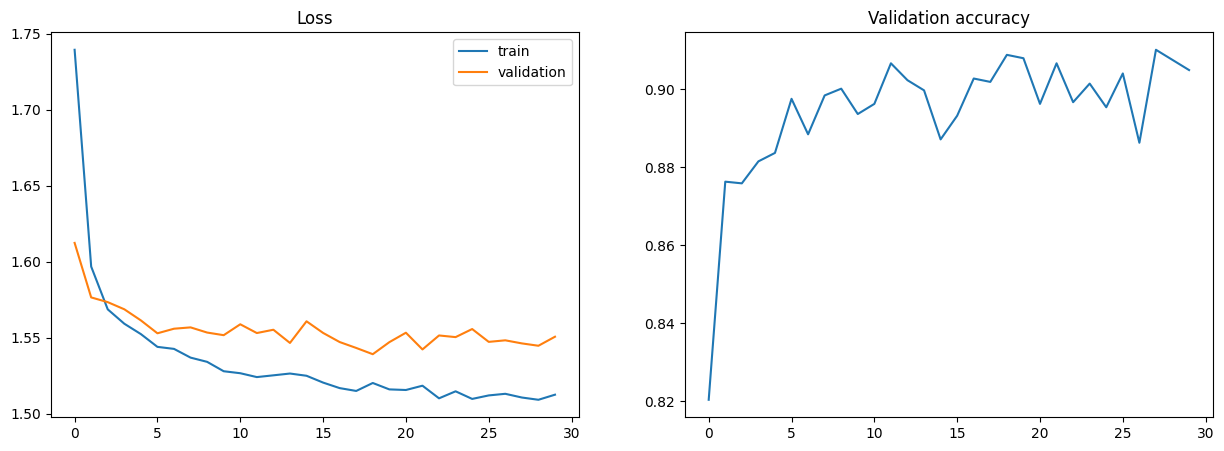

In [78]:
plot_train_process(train_loss, val_loss, val_accuracy)

### Batchnorm try

In [83]:
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.BatchNorm1d(200),
    nn.ReLU(),
    nn.Linear(200, 10),
    nn.Sigmoid(),
)
model.to(device, torch.float32)
loss_func = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 6.221s
	  training loss: 1.753112
	validation loss: 1.599926
	validation accuracy: 0.898
Epoch 2 of 30 took 4.339s
	  training loss: 1.592773
	validation loss: 1.574689
	validation accuracy: 0.885
Epoch 3 of 30 took 3.505s
	  training loss: 1.548594
	validation loss: 1.574845
	validation accuracy: 0.890
Epoch 4 of 30 took 2.502s
	  training loss: 1.532505
	validation loss: 1.561638
	validation accuracy: 0.901
Epoch 5 of 30 took 2.943s
	  training loss: 1.512884
	validation loss: 1.551517
	validation accuracy: 0.910
Epoch 6 of 30 took 2.236s
	  training loss: 1.505388
	validation loss: 1.555442
	validation accuracy: 0.907
Epoch 7 of 30 took 1.969s
	  training loss: 1.497634
	validation loss: 1.550345
	validation accuracy: 0.905
Epoch 8 of 30 took 2.061s
	  training loss: 1.494536
	validation loss: 1.555488
	validation accuracy: 0.901
Epoch 9 of 30 took 1.987s
	  training loss: 1.492655
	validation loss: 1.546568
	validation accuracy: 0.910
Epoch 10 of 30 took 1.942s
	

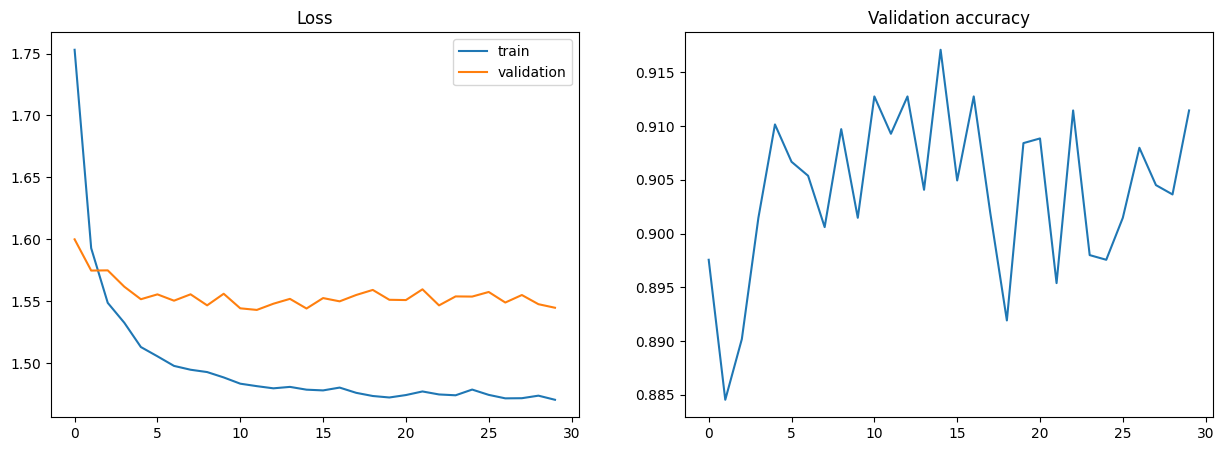

In [84]:
plot_train_process(train_loss, val_loss, val_accuracy)

### 3. Save the model (model checkpointing)

Now we have trained a model! Obviously we do not want to retrain the model everytime we want to use it. Plus if you are training a super big model, you probably want to save checkpoint periodically so that you can always fall back to the last checkpoint in case something bad happened or you simply want to test models at different training iterations.

Model checkpointing is fairly simple in PyTorch. First, we define a helper function that can save a model to the disk

In [85]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [91]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self, input_size = 784, num_classes = 10):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        self.model = nn.Sequential(
            nn.Linear(input_size, 500),
            nn.ReLU(),
            nn.Linear(500, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Linear(200, num_classes),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [93]:
def test_model(model, val_loader):

    val_accuracy = []
    
    ep_val_accuracy = []
    model.train(False)
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(X_batch)
            pred = pred.max(dim = 1)[1]
            accr = (pred == y_batch).cpu().detach().numpy().mean()
            ep_val_accuracy.append(accr)


    val_accuracy.append(np.mean(ep_val_accuracy))
    
    print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return val_accuracy

In [95]:
# create a brand new model
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Testing -- you should get a pretty poor performance since the model hasn't learned anything yet.
test_model(model, val_loader)

	validation accuracy: 0.105


[0.10503472222222221]

#### Define a training loop with model checkpointing

In [99]:
def train_save(trainset_loader, epoch, save_interval, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target.long())
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            # different from before: saving model checkpoints
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)
            iteration += 1
        test_model(model, val_loader)
    
    # save the final model
    save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)

In [100]:
train_save(train_loader, 5, save_interval=500, log_interval=100)

Train Epoch: 0 [0/2996 (0%)]	Loss: -0.539493
	validation accuracy: 0.744
Train Epoch: 1 [192/2996 (6%)]	Loss: -0.843530
	validation accuracy: 0.800
Train Epoch: 2 [384/2996 (13%)]	Loss: -0.983366
	validation accuracy: 0.806
Train Epoch: 3 [576/2996 (19%)]	Loss: -0.990627
	validation accuracy: 0.806
Train Epoch: 4 [768/2996 (26%)]	Loss: -0.996922
	validation accuracy: 0.805
model saved to mnist-470.pth


In [101]:
!ls mnist*.pth

"ls" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [103]:
# create a new model
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# load from the final checkpoint
load_checkpoint('mnist-470.pth', model, optimizer)
# should give you the final model accuracy
test_model(model, val_loader)

model loaded from mnist-470.pth


	validation accuracy: 0.800


[0.8003472222222223]

```

```

```

```

```

```

```

```

```

```
### More about pytorch:
* Using torch on GPU and multi-GPU - [link](http://pytorch.org/docs/master/notes/cuda.html)
* More tutorials on pytorch - [link](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* Pytorch examples - a repo that implements many cool DL models in pytorch - [link](https://github.com/pytorch/examples)
* Practical pytorch - a repo that implements some... other cool DL models... yes, in pytorch - [link](https://github.com/spro/practical-pytorch)
* And some more - [link](https://www.reddit.com/r/pytorch/comments/6z0yeo/pytorch_and_pytorch_tricks_for_kaggle/)